## Table of Content:
* [Data Preparation & Visualisation](#data-prep-viz)
* [Machine Learning](#ml)

In [210]:
import requests
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
from skimpy import skim

In [211]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Data Preparation & Visualisation <a class="anchor" id="data-prep-viz"></a>

## Helper Functions

In [212]:
NUMPY_INTS = [numpy.dtypes.Float64DType,numpy.dtypes.Float32DType, numpy.dtypes.Int64DType, numpy.dtypes.Int32DType]

def fetch_data(url, out_file):
  res = requests.get(url)
  if res.content:
    with open(out_file, "w") as csv_file:
      writer = csv.writer(csv_file)
      content = res.content.decode("utf-8").split("\n")
      for line in content:
        line = [entry.replace('"', '').replace('\r', '') for entry in line.split(",")]
        writer.writerow(line)

# Returns a cleaned up dataframe
def do_basic_cleanup(df, drop_cols):
    try:
      df = df.drop(columns=drop_cols)
    except Exception as e:
      print(e)
    df = df.rename(columns={c: c.lower().replace(" ", "_").replace("(", "").replace(")", "") for c in df.columns})
    return df

# returns a series with Value counts, where ....
# https://www.kaggle.com/code/parulpandey/five-ways-to-use-value-counts
def value_counts(df):
    res = []
    for col in df.columns:
      preliminary_res = df[col].value_counts()
      if preliminary_res.size > 20:
        if type(df[col].dtype) in NUMPY_INTS:
          preliminary_res = df[col].value_counts(bins=10)
          preliminary_res.name = preliminary_res.name + "- BINNED"
        else:
          preliminary_res = df[col].value_counts(normalize=True)  
          preliminary_res.name = preliminary_res.name + "- NORMALIZED"
      res.append(preliminary_res)
    return res

def cast_cols_to_str(df, cols):
    for col in cols:
      df[col] = df[col].astype(str)


In [213]:
# Source: https://data.cso.ie/table/ASA02
fetch_data("https://ws.cso.ie/public/api.restful/PxStat.Data.Cube_API.ReadDataset/ASA02/CSV/1.0/en", "irl_tourism.csv")

In [214]:
df = pd.read_csv("irl_tourism.csv", on_bad_lines='warn')
df.head()

,STATISTIC,STATISTIC Label,TLIST(A1),Year,C02293V02763,Direction,C03042V03675,Route,UNIT,VALUE
0,ASA02,Air and Sea Travel,2010.0,2010.0,1.0,Arrivals,-,All routes of travel,Thousand,12902.2
1,ASA02,Air and Sea Travel,2010.0,2010.0,1.0,Arrivals,01,Cross channel,Thousand,6113.0
2,ASA02,Air and Sea Travel,2010.0,2010.0,1.0,Arrivals,02,Continental Europe,Thousand,5652.6
3,ASA02,Air and Sea Travel,2010.0,2010.0,1.0,Arrivals,03,Transatlantic,Thousand,914.5
4,ASA02,Air and Sea Travel,2010.0,2010.0,1.0,Arrivals,04,Other,Thousand,222.1


In [215]:
df = do_basic_cleanup(df, ["STATISTIC", "STATISTIC Label", "TLIST(A1)", "C02293V02763", "C03042V03675", "UNIT"])

df = df.dropna()
df = df.astype({"year": int})
df.head()

,year,direction,route,value
0,2010,Arrivals,All routes of travel,12902.2
1,2010,Arrivals,Cross channel,6113.0
2,2010,Arrivals,Continental Europe,5652.6
3,2010,Arrivals,Transatlantic,914.5
4,2010,Arrivals,Other,222.1


,year,direction,route,value
135,2023,Departures,All routes of travel,20626.2
136,2023,Departures,Cross channel,7216.1
137,2023,Departures,Continental Europe,10485.0
138,2023,Departures,Transatlantic,2139.5
139,2023,Departures,Other,785.6


In [216]:
#df.apply(lambda col: col.value_counts(), axis=1)
#skim(df)
df['value'].value_counts(bins=7)
print(type(df['value'].dtype))

(128.722, 3074.486]       64
(5999.771, 8925.057]      33
(3074.486, 5999.771]      12
(11850.343, 14775.629]    10
(17700.914, 20626.2]       8
(8925.057, 11850.343]      7
(14775.629, 17700.914]     6
Name: count, dtype: int64

<class 'numpy.dtypes.Float64DType'>


## Looking at arrivals from different destinations 

In [217]:
arrivals = df[(df['direction'] == 'Arrivals') & (df['route'] != 'All routes of travel')]
departures = df[(df['direction'] == 'Departures') & (df['route'] != 'All routes of travel')]

In [218]:
arrivals.head()

,year,direction,route,value
1,2010,Arrivals,Cross channel,6113.0
2,2010,Arrivals,Continental Europe,5652.6
3,2010,Arrivals,Transatlantic,914.5
4,2010,Arrivals,Other,222.1
11,2011,Arrivals,Cross channel,6102.5


Text(0.5, 1.0, 'Number of Arrivals Into Ireland')

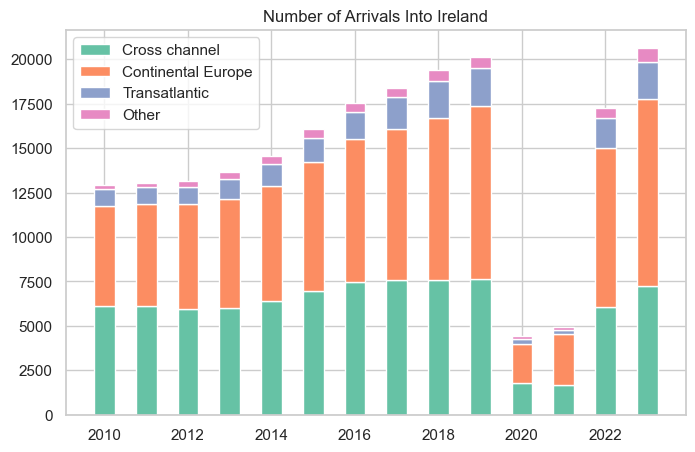

In [219]:
#sns.set_theme(style="whitegrid")

#ax = sns.barplot(data=arrivals, x="year", y="value", hue="route", palette='flare')

x = arrivals['year'].unique()
routes = arrivals['route'].unique()
bottom = np.zeros(len(x))
palette = sns.color_palette("Set2")

_, ax= plt.subplots(figsize=(8, 5))
width = 0.5

#for year in x:
for i, route in enumerate(routes):
   data = arrivals[arrivals['route'] == route]['value']
   _ = ax.bar(x, data, width, label=route, bottom=bottom, color=palette[i])
   bottom += data.to_numpy()

ax.set_title("Number of Arrivals Into Ireland")
ax.legend(loc="upper left")


## Explore percent change Year over Year

In [222]:
arrivals_cols = arrivals.set_index(['year', 'route'])['value'].unstack()
raw_cols = arrivals_cols.columns
new_cols = []
for c in arrivals_cols.columns.to_numpy():
    new_col = "ptc_ch_" + c.lower().replace(" ", "_")
    new_cols.append(new_col)
    arrivals_cols[new_col] = round(arrivals_cols[c].pct_change() * 100, 2)
arrivals_cols = arrivals_cols.drop(columns=raw_cols)
arrivals_cols = arrivals_cols.reset_index()
arrivals_cols.head()

route,year,ptc_ch_continental_europe,ptc_ch_cross_channel,ptc_ch_other,ptc_ch_transatlantic
0,2010,NaN,NaN,NaN,NaN
1,2011,2.30,-0.17,4.55,1.97
2,2012,2.38,-2.82,43.84,2.68
3,2013,3.72,1.44,14.85,14.16
4,2014,5.09,6.75,12.96,13.31


In [223]:
a = arrivals_cols.melt(id_vars=['year'], value_vars=new_cols)
a.head()

,year,route,value
0,2010,ptc_ch_continental_europe,NaN
1,2011,ptc_ch_continental_europe,2.30
2,2012,ptc_ch_continental_europe,2.38
3,2013,ptc_ch_continental_europe,3.72
4,2014,ptc_ch_continental_europe,5.09


<Axes: xlabel='year', ylabel='value'>

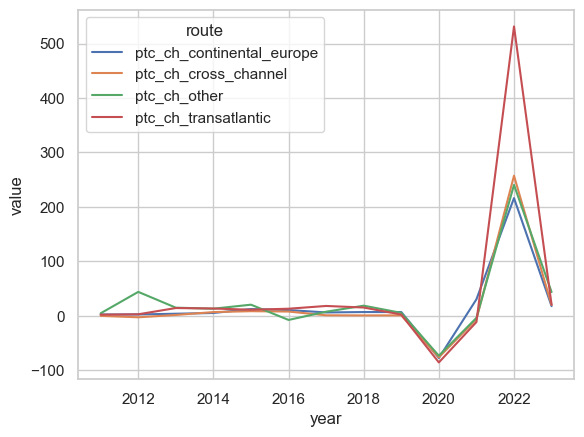

In [398]:
sns.lineplot(data=a, x="year", y="value", hue="route")

## Flights to Ireland from other international airports
1. Data from https://ec.europa.eu/eurostat/web/transport/data/database
2. https://ec.europa.eu/eurostat/databrowser/explore/all/transp?lang=en&subtheme=avia.avia_pa.avia_par&display=list&sort=category&extractionId=avia_par_ie
3. Explanatory notes on the data https://ec.europa.eu/eurostat/databrowser/view/avia_par_ie/default/table?lang=en
4. API https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/dataflow/ESTAT/avia_par_ie$defaultview/1.0?references=descendants&detail=referencepartial&format=sdmx_2.1_generic&compressed=true

|Dimension	| Agency : Code list | Values |
| --- | --- | --- |
|FREQ | Time frequency	ESTAT : FREQ | Annual, Quarterly, Monthly ||
|UNIT | Unit of measure	ESTAT : UNIT | Passenger, Flights, Seats and berths||
|TRA_MEAS | Traffic and transport measurement	ESTAT : TRA_MEAS ||
|AIRP_PR | Airport pairs (routes)	ESTAT : AIRP_PR ||
|OBS_FLAG | Observation status (Flag)	ESTAT : OBS_FLAG ||

In [226]:
#IRL_AIRPORT_PASS_TRAVEL = "https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/dataflow/ESTAT/avia_par_ie$defaultview/1.0?references=descendants&detail=referencepartial&format=sdmx_2.1_generic&compressed=true"
# https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/avia_par_ie/?format=SDMX-CSV&lang=en&label=both
# https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/avia_par_ie/?format=TSV
# https://ec.europa.eu/eurostat/databrowser/view/avia_par_ie/default/table?lang=en&category=avia.avia_pa.avia_par

# https://ec.europa.eu/eurostat/databrowser/view/avia_par_ie/default/table?lang=en&category=avia.avia_pa.avia_par

### ONLY REPLAY IF DATASET IS MISSING< IT IS VERY BIG
fetch_data("https://ec.europa.eu/eurostat/api/dissemination/sdmx/3.0/data/dataflow/ESTAT/avia_par_ie/1.0?compress=false&format=csvdata&formatVersion=2.0&lang=en&labels=name", 
           "flights.csv")

In [376]:
# Cannot commit the dataset to GitHub, as it is beyond the file size allowd by GH
# Replay the previous step to generate the dataset
# low_memory=False due to mixed datatypes
flights = pd.read_csv("flights.csv", low_memory=False)

In [377]:
#pd.set_option('display.max_columns', 100)
#pd.set_option('display.width', 1000)
#flights.columns
flights.head()

,STRUCTURE,STRUCTURE_ID,STRUCTURE_NAME,freq,Time frequency,unit,Unit of measure,tra_meas,Traffic and transport measurement,airp_pr,Airport pairs (routes),TIME_PERIOD,Time,OBS_VALUE,Observation value,OBS_FLAG,Observation status (Flag)
0,dataflow,ESTAT:AVIA_PAR_IE(1.0),Air passenger transport between the main airpo...,A,Annual,FLIGHT,Flight,CAF_PAS,Commercial passenger air flights,IE_EICK_BE_EBBR,CORK airport - BRUSSELS airport,2012,NaN,256.0,NaN,NaN,NaN
1,dataflow,ESTAT:AVIA_PAR_IE(1.0),Air passenger transport between the main airpo...,A,Annual,FLIGHT,Flight,CAF_PAS,Commercial passenger air flights,IE_EICK_BE_EBBR,CORK airport - BRUSSELS airport,2013,NaN,248.0,NaN,NaN,NaN
2,dataflow,ESTAT:AVIA_PAR_IE(1.0),Air passenger transport between the main airpo...,A,Annual,FLIGHT,Flight,CAF_PAS,Commercial passenger air flights,IE_EICK_CH_LSZH,CORK airport - ZURICH airport,2019,NaN,213.0,NaN,NaN,NaN
3,dataflow,ESTAT:AVIA_PAR_IE(1.0),Air passenger transport between the main airpo...,A,Annual,FLIGHT,Flight,CAF_PAS,Commercial passenger air flights,IE_EICK_CZ_LKPR,CORK airport - PRAHA/RUZYNE airport,2003,NaN,296.0,NaN,NaN,NaN
4,dataflow,ESTAT:AVIA_PAR_IE(1.0),Air passenger transport between the main airpo...,A,Annual,FLIGHT,Flight,CAF_PAS,Commercial passenger air flights,IE_EICK_CZ_LKPR,CORK airport - PRAHA/RUZYNE airport,2004,NaN,557.0,NaN,NaN,NaN


In [378]:
# Remove column repetitions
flights = do_basic_cleanup(flights, ["STRUCTURE", "STRUCTURE_ID", "STRUCTURE_NAME", 
                                     "freq", 'unit', 'Time', 'Observation value', 'Observation status (Flag)', 'OBS_FLAG', 'tra_meas', 'Airport pairs (routes)'])

In [379]:
flights.dtypes
value_counts(flights)

time_frequency                        object
unit_of_measure                       object
traffic_and_transport_measurement     object
airp_pr                               object
time_period                           object
obs_value                            float64
dtype: object

[time_frequency
 Monthly      370798
 Quarterly    126827
 Annual        31623
 Name: count, dtype: int64,
 unit_of_measure
 Passenger           270142
 Seats and berths    129621
 Flight              129485
 Name: count, dtype: int64,
 traffic_and_transport_measurement
 Passengers carried                               46912
 Passengers carried (arrival)                     46826
 Passengers carried (departures)                  46783
 Passengers on board                              43279
 Passengers seats available                       43279
 Commercial passenger air flights                 43228
 Passengers on board (arrivals)                   43188
 Passengers seats available (arrivals)            43188
 Passengers on board (departures)                 43154
 Passengers seats available (departures)          43154
 Commercial passenger air flights (arrivals)      43143
 Commercial passenger air flights (departures)    43114
 Name: count, dtype: int64,
 airp_pr
 IE_EIDW_UK_EGSS    

In [380]:
flights_m = flights[flights['time_frequency'] == 'Monthly']

In [381]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
pd.options.mode.copy_on_write = True
flights_m[['year', 'month']] = flights_m['time_period'].str.split('-', expand=True)
flights_m = flights_m.drop(columns=['time_period', 'time_frequency'])

In [382]:
flights_m.head()

,time_frequency,unit_of_measure,traffic_and_transport_measurement,airp_pr,obs_value,year,month
31623,Monthly,Flight,Commercial passenger air flights,IE_EICK_BE_EBBR,6.0,2012,03
31624,Monthly,Flight,Commercial passenger air flights,IE_EICK_BE_EBBR,26.0,2012,04
31625,Monthly,Flight,Commercial passenger air flights,IE_EICK_BE_EBBR,26.0,2012,05
31626,Monthly,Flight,Commercial passenger air flights,IE_EICK_BE_EBBR,26.0,2012,06
31627,Monthly,Flight,Commercial passenger air flights,IE_EICK_BE_EBBR,26.0,2012,07


In [383]:
#flights_m[['year', 'quarter']] = flights_m['time_period'].str.split('-', expand=True)
#flights_m[['domestic_airpot', 'international_airport']] 
flights_m['airp_pr'].apply(lambda x: len(x)).value_counts()

# Same lengths, so we can attempt to split the pairs
flights_m['domestic_airpot']  = flights_m['airp_pr'].apply(lambda x: x[:7])
flights_m['international_airport'] = flights_m['airp_pr'].apply(lambda x: x[8:15])
flights_m.drop(columns=['airp_pr'], inplace=True)

flights_m['domestic_airpot'].value_counts()
flights_m['international_airport'].value_counts()

airp_pr
15    370798
Name: count, dtype: int64

domestic_airpot
IE_EIDW    217466
IE_EICK     60768
IE_EINN     54716
IE_EIKN     22844
IE_EIKY     12016
IE_EICM      2988
Name: count, dtype: int64

international_airport
UK_EGSS    14119
UK_EGCC    12208
UK_EGKK    10485
UK_EGBB    10410
ES_GCRR     9855
           ...  
US_KDFW       84
UK_EGAA       66
ZZ_ZZZZ       65
EL_LGIR       54
UK_EGHD       36
Name: count, Length: 141, dtype: int64

In [404]:
flights_m.head()

,unit_of_measure,traffic_and_transport_measurement,obs_value,year,month,domestic_airpot,international_airport,country_code,continent_name
31623,Flight,Commercial passenger air flights,6.0,2012,03,IE_EICK,BE_EBBR,Belgium,Europe
31624,Flight,Commercial passenger air flights,26.0,2012,04,IE_EICK,BE_EBBR,Belgium,Europe
31625,Flight,Commercial passenger air flights,26.0,2012,05,IE_EICK,BE_EBBR,Belgium,Europe
31626,Flight,Commercial passenger air flights,26.0,2012,06,IE_EICK,BE_EBBR,Belgium,Europe
31627,Flight,Commercial passenger air flights,26.0,2012,07,IE_EICK,BE_EBBR,Belgium,Europe


In [405]:
# res = requests.get('https://gist.githubusercontent.com/ssskip/5a94bfcd2835bf1dea52/raw/3b2e5355eb49336f0c6bc0060c05d927c2d1e004/ISO3166-1.alpha2.json')
# take this maybe?

res = requests.get('https://gist.githubusercontent.com/fogonwater/bc2b98baeb2aa16b5e6fbc1cf3d7d545/raw/6fd2951260d8f171181a45d2f09ee8b2c7767330/countries.json')
country_codes = json.loads(res.content.decode("utf-8"))

In [406]:
country_codes

{'AD': {'continent_code': 'EU',
  'continent_name': 'Europe',
  'country_code2': 'AD',
  'country_code3': 'AND',
  'country_name': 'Andorra',
  'country_name_full': 'Principality of Andorra',
  'iso3': '020'},
 'AE': {'continent_code': 'AS',
  'continent_name': 'Asia',
  'country_code2': 'AE',
  'country_code3': 'ARE',
  'country_name': 'United Arab Emirates',
  'country_name_full': 'United Arab Emirates',
  'iso3': '784'},
 'AF': {'continent_code': 'AS',
  'continent_name': 'Asia',
  'country_code2': 'AF',
  'country_code3': 'AFG',
  'country_name': 'Afghanistan',
  'country_name_full': 'Islamic Republic of Afghanistan',
  'iso3': '004'},
 'AG': {'continent_code': 'NA',
  'continent_name': 'North America',
  'country_code2': 'AG',
  'country_code3': 'ATG',
  'country_name': 'Antigua and Barbuda',
  'country_name_full': 'Antigua and Barbuda',
  'iso3': '028'},
 'AI': {'continent_code': 'NA',
  'continent_name': 'North America',
  'country_code2': 'AI',
  'country_code3': 'AIA',
  'coun

In [408]:
# According to https://www.destatis.de/Europa/EN/Country/Country-Codes.html Greece is assigned GR country code, however, on Eurostate it is EL
# In our countries mapping, we only have GR, so we can add an entry for Greece in our `country_codes`

country_codes['EL'] = {'continent_code': 'EU',
  'continent_name': 'Europe',
  'country_code2': 'GR',
  'country_code3': 'GRC',
  'country_name': 'Greece'}

In [409]:
flights_m['country_code'] = flights_m['international_airport'].apply(
    lambda x: country_codes[x[0:2]]['country_name'] if x[0:2] in country_codes else x[0:2])

flights_m['continent_name'] = flights_m['international_airport'].apply(
    lambda x: country_codes[x[0:2]]['continent_name'] if x[0:2] in country_codes else x[0:2])

In [410]:
passengers_arr_month = flights_m.loc[(flights_m['unit_of_measure'] == 'Passenger') & (flights_m['traffic_and_transport_measurement'] == 'Passengers on board (arrivals)')]
passengers_dep_month = flights_m.loc[(flights_m['unit_of_measure'] == 'Passenger') & (flights_m['traffic_and_transport_measurement'] == 'Passengers on board (departures)')]

flights_arr_month = flights_m.loc[(flights_m['unit_of_measure'] == 'Flight') & (flights_m['traffic_and_transport_measurement'] == 'Commercial passenger air flights (arrivals)')]
flights_dep_month = flights_m.loc[(flights_m['unit_of_measure'] == 'Flight') & (flights_m['traffic_and_transport_measurement'] == 'Commercial passenger air flights (departures)')]

#flights_pass_q = flights_pass_q.drop(columns=['time_frequency', 'unit_of_measure', 'traffic_and_transport_measurement', 'tra_meas', 'obs_flag'])
# flights_pass_q.head()
# flights_pass_q.size
# https://store.icao.int/en/location-indicators-doc-7910 to map to 


In [411]:
component_dfs = [passengers_arr_month, passengers_dep_month, flights_arr_month, flights_dep_month]

for df in component_dfs:
  df.head()

for df in component_dfs:
  df.shape

,unit_of_measure,traffic_and_transport_measurement,obs_value,year,month,domestic_airpot,international_airport,country_code,continent_name
152840,Passenger,Passengers on board (arrivals),271.0,2012,03,IE_EICK,BE_EBBR,Belgium,Europe
152841,Passenger,Passengers on board (arrivals),1346.0,2012,04,IE_EICK,BE_EBBR,Belgium,Europe
152842,Passenger,Passengers on board (arrivals),1377.0,2012,05,IE_EICK,BE_EBBR,Belgium,Europe
152843,Passenger,Passengers on board (arrivals),1082.0,2012,06,IE_EICK,BE_EBBR,Belgium,Europe
152844,Passenger,Passengers on board (arrivals),1550.0,2012,07,IE_EICK,BE_EBBR,Belgium,Europe


,unit_of_measure,traffic_and_transport_measurement,obs_value,year,month,domestic_airpot,international_airport,country_code,continent_name
183148,Passenger,Passengers on board (departures),307.0,2012,03,IE_EICK,BE_EBBR,Belgium,Europe
183149,Passenger,Passengers on board (departures),1321.0,2012,04,IE_EICK,BE_EBBR,Belgium,Europe
183150,Passenger,Passengers on board (departures),1344.0,2012,05,IE_EICK,BE_EBBR,Belgium,Europe
183151,Passenger,Passengers on board (departures),1152.0,2012,06,IE_EICK,BE_EBBR,Belgium,Europe
183152,Passenger,Passengers on board (departures),1383.0,2012,07,IE_EICK,BE_EBBR,Belgium,Europe


,unit_of_measure,traffic_and_transport_measurement,obs_value,year,month,domestic_airpot,international_airport,country_code,continent_name
61956,Flight,Commercial passenger air flights (arrivals),3.0,2012,03,IE_EICK,BE_EBBR,Belgium,Europe
61957,Flight,Commercial passenger air flights (arrivals),13.0,2012,04,IE_EICK,BE_EBBR,Belgium,Europe
61958,Flight,Commercial passenger air flights (arrivals),13.0,2012,05,IE_EICK,BE_EBBR,Belgium,Europe
61959,Flight,Commercial passenger air flights (arrivals),13.0,2012,06,IE_EICK,BE_EBBR,Belgium,Europe
61960,Flight,Commercial passenger air flights (arrivals),13.0,2012,07,IE_EICK,BE_EBBR,Belgium,Europe


,unit_of_measure,traffic_and_transport_measurement,obs_value,year,month,domestic_airpot,international_airport,country_code,continent_name
92225,Flight,Commercial passenger air flights (departures),3.0,2012,03,IE_EICK,BE_EBBR,Belgium,Europe
92226,Flight,Commercial passenger air flights (departures),13.0,2012,04,IE_EICK,BE_EBBR,Belgium,Europe
92227,Flight,Commercial passenger air flights (departures),13.0,2012,05,IE_EICK,BE_EBBR,Belgium,Europe
92228,Flight,Commercial passenger air flights (departures),13.0,2012,06,IE_EICK,BE_EBBR,Belgium,Europe
92229,Flight,Commercial passenger air flights (departures),13.0,2012,07,IE_EICK,BE_EBBR,Belgium,Europe


(30308, 9)

(30271, 9)

(30269, 9)

(30238, 9)

In [414]:
passengers_arr_month.rename(columns={"obs_value": "num_passangers_arrivals"}, inplace=True)
passengers_dep_month.rename(columns={"obs_value": "num_passangers_departures"}, inplace=True)
flights_arr_month.rename(columns={"obs_value": "num_flights_arrivals"}, inplace=True)
flights_dep_month.rename(columns={"obs_value": "num_flights_departures"}, inplace=True)

In [415]:
for df in component_dfs:
  df.drop(columns=['unit_of_measure', 'traffic_and_transport_measurement'], inplace=True)

In [416]:
shapes = {
    'passengers_arr_month': passengers_arr_month.shape[0],
    'passengers_dep_month': passengers_dep_month.shape[0],
    'flights_arr_month': flights_arr_month.shape[0],
    'flights_dep_month': flights_dep_month.shape[0],
}
shapes

{'passengers_arr_month': 30308,
 'passengers_dep_month': 30271,
 'flights_arr_month': 30269,
 'flights_dep_month': 30238}

In [418]:
# Since the dataframes differ in size, do an outer join to ensure we have all values for now
keys = ['year', 'month', 'domestic_airpot', 'international_airport', 'country_code', 'continent_name']
merged_df = passengers_arr_month.merge(passengers_dep_month, on=keys, how='outer')
merged_df = merged_df.merge(flights_arr_month, on=keys, how='outer')
merged_df = merged_df.merge(flights_dep_month, on=keys, how='outer')

In [419]:
merged_df = merged_df.reindex(columns=['year','month',	'domestic_airpot','international_airport', 'country_code', 'continent_name','num_passangers_arrivals','num_passangers_departures','num_flights_arrivals','num_flights_departures'])


In [420]:
merged_df.shape
merged_df.describe()

(30377, 10)

,num_passangers_arrivals,num_passangers_departures,num_flights_arrivals,num_flights_departures
count,30308.000000,30271.000000,30269.000000,30238.000000
mean,8049.012868,8082.150904,62.447521,62.570077
std,9887.337330,9931.814016,76.315285,76.591132
min,0.000000,0.000000,0.000000,1.000000
25%,2562.750000,2591.000000,22.000000,22.000000
50%,4893.000000,4904.000000,35.000000,35.000000
75%,9364.000000,9422.000000,69.000000,69.000000
max,100056.000000,99288.000000,650.000000,1123.000000


In [421]:
merged_df.head(10)

,year,month,domestic_airpot,international_airport,country_code,continent_name,num_passangers_arrivals,num_passangers_departures,num_flights_arrivals,num_flights_departures
0,2012,03,IE_EICK,BE_EBBR,Belgium,Europe,271.0,307.0,3.0,3.0
1,2012,04,IE_EICK,BE_EBBR,Belgium,Europe,1346.0,1321.0,13.0,13.0
2,2012,05,IE_EICK,BE_EBBR,Belgium,Europe,1377.0,1344.0,13.0,13.0
3,2012,06,IE_EICK,BE_EBBR,Belgium,Europe,1082.0,1152.0,13.0,13.0
4,2012,07,IE_EICK,BE_EBBR,Belgium,Europe,1550.0,1383.0,13.0,13.0
5,2012,08,IE_EICK,BE_EBBR,Belgium,Europe,1456.0,1551.0,14.0,14.0
6,2012,09,IE_EICK,BE_EBBR,Belgium,Europe,1004.0,968.0,12.0,12.0
7,2012,10,IE_EICK,BE_EBBR,Belgium,Europe,1515.0,1361.0,15.0,15.0
8,2012,11,IE_EICK,BE_EBBR,Belgium,Europe,1345.0,1619.0,16.0,16.0
9,2012,12,IE_EICK,BE_EBBR,Belgium,Europe,1597.0,1305.0,16.0,16.0


In [433]:
merged_df['continent_name'].value_counts()
merged_df['country_code'].value_counts()

continent_name
Europe           17051
UK                9845
North America     2904
Asia               574
ZZ                   3
Name: count, dtype: int64

country_code
UK                            9845
Spain                         4759
United States of America      2740
Germany                       1716
Poland                        1694
France                        1494
Italy                         1353
Portugal                       996
Ireland                        849
Netherlands                    675
Belgium                        524
Switzerland                    428
Lithuania                      401
United Arab Emirates           320
Czech Republic                 297
Hungary                        266
Denmark                        245
Austria                        232
Latvia                         212
Turkey                         173
Canada                         164
Slovakia (Slovak Republic)     156
Norway                         142
Romania                        130
Sweden                         118
Malta                           88
Qatar                           70
Iceland                         70
Greece 

In [434]:
merged_df = merged_df.loc[(merged_df['country_code'] != 'ZZ')]

/var/folders/z7/8n2dlxg16tggjrtnz6s70x180000gn/T/ipykernel_43312/1782698178.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = a.set_xticklabels(a.get_xticklabels(), rotation=35)


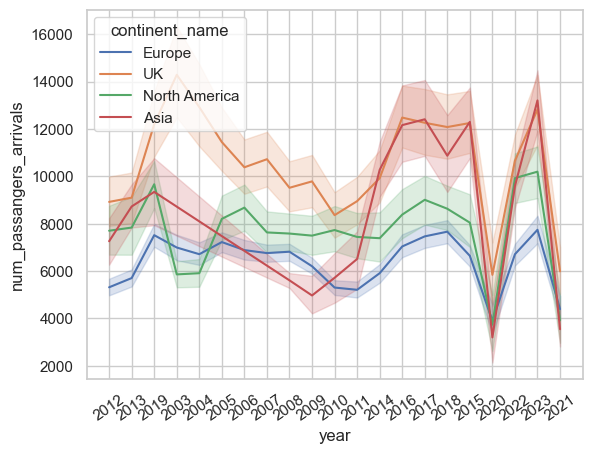

In [436]:
a = sns.lineplot(data=merged_df, x='year', y='num_passangers_arrivals', hue='continent_name')
_ = a.set_xticklabels(a.get_xticklabels(), rotation=35)

## Machine Learning <a class="anchor" id="ml"></a>


In [ ]:
import numpy as np
from sklearn.preprocessing import scale, StandardScaler

# Generating example data with different scales
data = np.array([[1.0, 20.0, 300.0],
                 [4.0, 50.0, 600.0],
                 [7.0, 80.0, 900.0]])

print("Original data:\n", data)

# Method 1: Scaling using the scale function
scaled_data = scale(data)
print("\nScaled data using scale function:\n", scaled_data)

# Method 2: Using StandardScaler
scaler = StandardScaler()
standardized_data = scaler.fit_transform(data)
print("\nStandardized data using StandardScaler:\n", standardized_data)

In [ ]:
# Model building

# instantiate an object of class SVC()
# note that we are using cost C=1
model = SVC(C = 1)

# fit
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)

print(y_pred)